# [Dataset]: Part-of-Speech (POS) Tagger
- In order to create our part-of-speeh tagger, we will use English words, setences and tags found in `https://github.com/UniversalDependencies/UD_English-EWT`. 
- This source provided 3 files (`train`, `dev` and `test`) in form of `.conllu`.
- The methods below are for loading the data.
    - Extract `setences`, `words` and `POS tags`

-  Field Structure of each file (train, dev, test)

    - Each row represents a **token** (word or punctuation mark) in the sentence and contains various linguistic features organized into columns. The format is:

        - **Token ID** (`1, 2, 3, ...`):  
        A unique number assigned to each word/token in the sentence.

        - **Token Form** (`Al, -, Zaman, etc.`):  
        The actual word or symbol in the text.

        - **Lemma** (`Al, -, Zaman, etc.`):  
        The base or dictionary form of the word.

        - **UPOS (Universal Part-of-Speech Tag)** (`PROPN, PUNCT, NOUN, VERB, etc.`):  
        The part of speech of the word according to UD (Universal Dependencies) guidelines.

        - **XPOS (Language-Specific Part-of-Speech Tag)** (`NNP, HYPH, JJ, etc.`):  
        A more fine-grained POS label specific to the language.

        - **Morphological Features** (`Number=Sing, Definite=Def, etc.`):  
        Grammatical features such as **singular/plural, tense, person, case, etc.**

        - **Head (Dependency Relation Index)** (`0, 3, 7, etc.`):  
        The index of the **head** (governing) word in the syntactic structure.

        - **Dependency Relation (UD Relation)** (`root, flat, punct, obj, etc.`):  
        The **syntactic role** of the word in relation to its head.

        - **Miscellaneous Information** (`SpaceAfter=No, etc.`):  
        Additional metadata, such as whether there is a space after a token.
    - Note: the first lines related to metadata.


In [46]:
import pandas as pd
import re
import requests
from tqdm import tqdm

In [48]:
def read_conllu_file(github_url: str):
    """
    Fetches a .conllu file dynamically from a given GitHub URL and extracts sentences,
    words, and POS tags into structured Pandas DataFrames.

    :param github_url: The raw URL to the .conllu file hosted on GitHub.
    :type github_url: str
    :return: A tuple containing two DataFrames:
        - **sent_df (pd.DataFrame):** DataFrame with sentences.
        - **words_df (pd.DataFrame):** DataFrame with words, sentence indices, and POS tags.
    :rtype: tuple[pd.DataFrame, pd.DataFrame]
    """
    # Fetch the file content from GitHub
    response = requests.get(github_url)

    # Check if the request was successful
    if response.status_code != 200:
        raise RuntimeError(f"Failed to fetch file from GitHub. HTTP Status Code: {response.status_code}")

    # Split the file content by lines to get a list of strings
    data_lines = response.text.strip().split("\n")

    # Initialize the list for the first dataframe (sentences)
    sentences = [] 
    # Initialize lists for the second dataframe (words, POS tags, sentence indices)
    words, pos_tags, index = [], [], [] 
    sentence_text = None  # Stores the current sentence text
    sentence_id = -1  # Keeps track of sentence indices

    for line in data_lines: # for eah string setence of the file 
        line = line.strip()  # Remove leading and trailing whitespace

        # Case 1: Empty line → Marks the end of a sentence
        if not line:
            if sentence_text:  # If a sentence has been collected
                # Add spacing inside the function before storing the sentence
                sentence_text = re.sub(r'(\w)([,.])', r'\1 \2', sentence_text)
                sentences.append(sentence_text)
                sentence_text = None  # Reset for the next sentence

        # Case 2: Line starts with "# text" → Indicates a new sentence
        # e.g.  # text = From the AP comes this story :
        elif line.startswith("# text"):
            sentence_id += 1  # Increment sentence index
            # Extract the actual sentence text and add start/end markers
            sentence_text = f"<s> {line.split('=', 1)[1].strip()} <e>"

        # Case 3: Any other line starting with "#" → Ignore metadata lines
        # e.g.  # newpar id = weblog-blogspot.com_nominations_20041117172713_ENG_20041117_172713-p0001
        elif line.startswith("#"):
            continue  # Skip comment lines

        # Case 4: Tokenized word data (columns separated by tabs)
        else:
            tokens = line.split("\t")  # Split the line into columns
            if len(tokens) > 3:  # Ensure it contains necessary columns
                words.append(tokens[1])       # Extract word (column 2)
                pos_tags.append(tokens[3])    # Extract POS tag (column 4)
                index.append(sentence_id)     # Associate word with sentence ID
    # return the two dataframes (sentences and worlds) 
    return pd.DataFrame({'Sentences': sentences}), pd.DataFrame({'Words': words, 'Sentence': index, 'POS': pos_tags})


In [49]:
# GitHub URLs for the English-EWT dataset (train test dev)
train_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"
dev_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu"
test_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"

# Load the datasets dynamically from GitHub
train_sent_df, train_words_df = read_conllu_file(train_url) # create dataset for traning set 
dev_sent_df, dev_words_df = read_conllu_file(dev_url) # create dataset for dev set  
test_sent_df, test_words_df = read_conllu_file(test_url) # create dataset for test set 

In [50]:
train_sent_df

,Sentences
0,<s> Al-Zaman : American forces killed Shaikh A...
1,<s> [This killing of a respected cleric will b...
2,<s> DPA: Iraqi authorities announced that they...
3,<s> Two of them were being run by 2 officials ...
4,<s> The MoI in Iraq is equivalent to the US FB...
...,...
12538,"<s> The next day , no one could find my wheel ..."
12539,"<s> Of course , they couldn't call him either ..."
12540,<s> On Monday I called and again it was a big ...
12541,<s> Supposedly they will be holding it for me ...


### Demostrate the Output of `train_words_df` for the first setence in teh dataset

- Fot the first setence being : 
    - `# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.`
    - **Being the fisr row of the df:train_sent_df**.
    - We apply a first preprocess step: 
        - `American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border.`
    - Then we generate the following output : 
        | Words     | Sentence | POS   |
        |-----------|----------|-------|
        | Al        | 0        | PROPN |
        | -         | 0        | PUNCT |
        | Zaman     | 0        | PROPN |
        | :         | 0        | PUNCT |
        | American  | 0        | ADJ   |
        | forces    | 0        | NOUN  |
        | killed    | 0        | VERB  |
        | Shaikh    | 0        | PROPN |
        | Abdullah  | 0        | PROPN |
        | al        | 0        | PROPN |
        | -         | 0        | PUNCT |
        | Ani       | 0        | PROPN |
        | ,         | 0        | PUNCT |
        | the       | 0        | DET   |
        | preacher  | 0        | NOUN  |
        | at        | 0        | ADP   |
        | the       | 0        | DET   |
        | mosque    | 0        | NOUN  |
        | in        | 0        | ADP   |
        | the       | 0        | DET   |
        | town      | 0        | NOUN  |
        | of        | 0        | ADP   |
        | Qaim      | 0        | PROPN |
        | ,         | 0        | PUNCT |
        | near      | 0        | ADP   |
        | the       | 0        | DET   |
        | Syrian    | 0        | ADJ   |
        | border    | 0        | NOUN  |
        | .         | 0        | PUNCT |

        

In [5]:
train_words_df.head(35)

,Words,Sentence,POS
0,Al,0,PROPN
1,-,0,PUNCT
2,Zaman,0,PROPN
3,:,0,PUNCT
4,American,0,ADJ
5,forces,0,NOUN
6,killed,0,VERB
7,Shaikh,0,PROPN
8,Abdullah,0,PROPN
9,al,0,PROPN


- at the end of the above output we can see index 1 meaning the words of the  next sentence 

In [59]:
train_sent_df['Sentences'].apply(lambda x: len(x.split())).mean()

17.50601929362991

In [7]:
len(train_words_df["Words"].unique())

20201

In [60]:
dev_sent_df, dev_words_df

(                                              Sentences
 0                <s> From the AP comes this story : <e>
 1     <s> President Bush on Tuesday nominated two in...
 2     <s> Bush nominated Jennifer M . Anderson for a...
 3                                           <s> *** <e>
 4     <s> Bush also nominated A . Noel Anketell Kram...
 ...                                                 ...
 1995  <s> All I can say is that Elmira you are the b...
 1996  <s> I recommend you to everyone in Calgary , a...
 1997                          <s> 5 star detail job <e>
 1998  <s> I took my Mustang here and it looked amazi...
 1999  <s> The paint and wheels looked like glass and...
 
 [2000 rows x 1 columns],
                Words  Sentence    POS
 0               From         0    ADP
 1                the         0    DET
 2                 AP         0  PROPN
 3              comes         0   VERB
 4               this         0    DET
 ...              ...       ...    ...
 25507         

In [61]:
dev_sent_df['Sentences'].apply(lambda x: len(x.split())).mean()

13.957

In [62]:
test_sent_df, test_words_df

(                                              Sentences
 0         <s> What if Google Morphed Into GoogleOS? <e>
 1     <s> What if Google expanded on its search-engi...
 2     <s> [via Microsoft Watch from Mary Jo Foley ] <e>
 3     <s> (And , by the way , is anybody else just a...
 4     <s> This BuzzMachine post argues that Google's...
 ...                                                 ...
 2071                         <s> HIGHLY recommend . <e>
 2072                                <s> thanks Rich <e>
 2073                                   <s> Seth K . <e>
 2074  <s> Deep tissue massage helps with pain in nec...
 2075  <s> Seth provides deep tissue massage which ha...
 
 [2076 rows x 1 columns],
             Words  Sentence    POS
 0            What         0   PRON
 1              if         0  SCONJ
 2          Google         0  PROPN
 3         Morphed         0   VERB
 4            Into         0    ADP
 ...           ...       ...    ...
 25445  suggesting      2076   VERB


In [11]:
test_sent_df['Sentences'].apply(lambda x: len(x.split())).mean()

13.471579961464354

In [63]:
train_words_df['POS'].unique(), test_words_df['POS'].unique(), dev_words_df['POS'].unique()

(array(['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX',
        'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', '_', 'INTJ', 'X',
        'SYM'], dtype=object),
 array(['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PUNCT', 'NOUN', 'CCONJ',
        'ADV', 'DET', 'ADJ', 'AUX', '_', 'PART', 'NUM', 'SYM', 'INTJ', 'X'],
       dtype=object),
 array(['ADP', 'DET', 'PROPN', 'VERB', 'NOUN', 'PUNCT', 'NUM', 'PART',
        'ADJ', 'ADV', 'AUX', 'PRON', 'CCONJ', 'SCONJ', '_', 'X', 'SYM',
        'INTJ'], dtype=object))

### Preprocess in order to be in the format of `Window`

In [64]:
def generate_three_word_windows(sentence):
    """
    Generates a list of three-word sliding windows from a given sentence, 
    excluding special tokens ('<s>' and '<e>').

    :param sentence: str
        The input sentence to process.
    :return: list
        A list of three-word windows, each represented as a list [Wi-1, Wi, Wi+1].
    """
    words = sentence.split()  # Split the sentence into words
    return [
        [words[i - 1], words[i], words[i + 1]]  # Create a window of three words
        for i in range(1, len(words) - 1)  # Ensure valid index range to avoid errors
        if words[i] not in {"<s>", "<e>"}  # Exclude special tokens
    ]

def generate_windows_dataframe(sentence_df, word_df, set_name):
    """
    Creates a DataFrame of word windows (Wi-1, Wi, Wi+1) along with 
    the POS tags of the center word from sentence and word data.

    :param sentence_df: pd.DataFrame
        DataFrame containing sentences under the column 'Sentences'.
    :param word_df: pd.DataFrame
        DataFrame containing word-level POS annotations with columns ['Words', 'Sentence', 'POS'].
    :param set_name: str
        A label identifying the dataset (e.g., "Development", "Test").
    :return: pd.DataFrame
        A DataFrame containing three-word windows and the corresponding POS tags of the center word.
    """
    
    # Initialize an empty dictionary to store the extracted word windows and POS tags
    new_data = {
                'Wi-1': [], 
                'Wi': [], 
                'Wi+1': [], 
                'Wi_POS_tag': []
            }

    # Iterate through each sentence in the dataset
    for idx, sentence in enumerate(tqdm(sentence_df['Sentences'], desc=f"Processing {set_name} Sentences")):
        word_windows = generate_three_word_windows(sentence)  # Generate three-word windows
        
        # Iterate through each three-word window in the sentence
        for window in word_windows:
            # Extract the POS tag for the center word (Wi) from the word_df DataFrame
            word_entry = word_df[(word_df["Words"] == window[1]) & (word_df["Sentence"] == idx)]
            
            # If the POS tag exists, store the window and its corresponding POS tag
            if not word_entry['POS'].empty:
                new_data['Wi-1'].append(window[0])  # Previous word (Wi-1)
                new_data['Wi'].append(window[1])   # Center word (Wi)
                new_data['Wi+1'].append(window[2]) # Next word (Wi+1)
                new_data['Wi_POS_tag'].append(word_entry['POS'].values[0])  # POS tag of Wi
           
    # Convert the dictionary into a Pandas DataFrame
    return pd.DataFrame(new_data)


In [65]:
# Generate the windows DataFrame for train, test and dev sets.

# train 
train_windows_df = generate_windows_dataframe(train_sent_df, 
                                              train_words_df, 
                                              "Train")
train_windows_df.to_csv("train_windows.csv", index=False)  # Save train set

# dev 
dev_windows_df = generate_windows_dataframe(dev_sent_df, 
                                            dev_words_df, 
                                            "Development")
dev_windows_df.to_csv("dev_windows.csv", index=False)      # Save development set

# test
test_windows_df = generate_windows_dataframe(test_sent_df, 
                                             test_words_df, 
                                             "Test")
test_windows_df.to_csv("test_windows.csv", index=False)    # Save test set

Processing Train Sentences:   0%|          | 0/12543 [00:00<?, ?it/s]

Processing Test Sentences: 100%|██████████| 2076/2076 [00:35<00:00, 59.10it/s] 


In [15]:
train_windows_df

,Wi-1,Wi,Wi+1,Wi_POS_tag
0,Al-Zaman,:,American,PUNCT
1,:,American,forces,ADJ
2,American,forces,killed,NOUN
3,forces,killed,Shaikh,VERB
4,killed,Shaikh,Abdullah,PROPN
...,...,...,...,...
185751,management,that,I,PRON
185752,that,I,could,PRON
185753,I,could,see,AUX
185754,could,see,.,VERB


### Preprocess

In [2]:
train_windows = pd.read_csv("./train_windows.csv")
test_windows = pd.read_csv("./test_windows.csv")
dev_windows = pd.read_csv("./dev_windows.csv")

In [3]:
train_windows['Wi_POS_tag'].unique()

array(['PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'DET', 'ADP', 'AUX',
       'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', '_', 'X', 'INTJ',
       'SYM'], dtype=object)

In [4]:
train_windows = train_windows[train_windows['Wi_POS_tag'] != "_"]
test_windows = test_windows[test_windows['Wi_POS_tag'] != "_"]
dev_windows = dev_windows[dev_windows['Wi_POS_tag'] != "_"]

In [5]:
import socket
import numpy as np
import gensim.downloader as api

In [6]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # Download English model
ft = fasttext.load_model('cc.en.300.bin') # load teh model in memory 

In [8]:
import numpy as np
import fasttext

def get_word_vector(word: str, ft: fasttext.FastText._FastText):
    """
    Retrieves the FastText word vector for a given word.

    :param word: The input word for which the vector is needed.
    :type word: str
    :param model: A loaded FastText model.
    :type model: fasttext.FastText._FastText

    :return: 
        - A NumPy array representing the word vector if successful.
        - None if the input is invalid or the model is not provided.
    :rtype: np.ndarray | None
    """
    if not isinstance(word, str) or not word.strip():
        print("Error: Input must be a non-empty string.")
        return None
    
    if not isinstance(ft, fasttext.FastText._FastText):
        print("Error: Invalid FastText model provided.")
        return None

    return ft.get_word_vector(word)

# Apply train set
train_windows['Ei-1'] = train_windows['Wi-1'].apply(lambda w: get_word_vector(w, ft))
train_windows['Ei'] = train_windows['Wi'].apply(lambda w: get_word_vector(w, ft))
train_windows['Ei+1'] = train_windows['Wi+1'].apply(lambda w: get_word_vector(w, ft))

# Apply test set
test_windows['Ei-1'] = test_windows['Wi-1'].apply(lambda w: get_word_vector(w, ft))
test_windows['Ei'] = test_windows['Wi'].apply(lambda w: get_word_vector(w, ft))
test_windows['Ei+1'] = test_windows['Wi+1'].apply(lambda w: get_word_vector(w, ft))

# Apply dev set
dev_windows['Ei-1'] = dev_windows['Wi-1'].apply(lambda w: get_word_vector(w, ft))
dev_windows['Ei'] = dev_windows['Wi'].apply(lambda w: get_word_vector(w, ft))
dev_windows['Ei+1'] = dev_windows['Wi+1'].apply(lambda w: get_word_vector(w, ft))


Error: Input must be a non-empty string.
Error: Input must be a non-empty string.
Error: Input must be a non-empty string.
Error: Input must be a non-empty string.
Error: Input must be a non-empty string.
Error: Input must be a non-empty string.
Error: Input must be a non-empty string.
Error: Input must be a non-empty string.


In [9]:
train_windows.isnull().sum()

Wi-1          3
Wi            3
Wi+1          0
Wi_POS_tag    0
Ei-1          3
Ei            3
Ei+1          0
dtype: int64

In [10]:
# preview the df with the embeddings
train_windows.dropna(inplace=True)
train_windows.head(5)

,Wi-1,Wi,Wi+1,Wi_POS_tag,Ei-1,Ei,Ei+1
0,Al-Zaman,:,American,PUNCT,"[-0.019236518, 0.010116229, -0.048779715, -0.0...","[0.15196927, 0.18509561, -0.091491126, -0.4385...","[-0.028939417, -0.010437311, 0.014177253, -0.0..."
1,:,American,forces,ADJ,"[0.15196927, 0.18509561, -0.091491126, -0.4385...","[-0.028939417, -0.010437311, 0.014177253, -0.0...","[-0.14300114, -0.08281179, 0.15055457, 0.00323..."
2,American,forces,killed,NOUN,"[-0.028939417, -0.010437311, 0.014177253, -0.0...","[-0.14300114, -0.08281179, 0.15055457, 0.00323...","[0.0368269, -0.008024149, 0.036501087, 0.05918..."
3,forces,killed,Shaikh,VERB,"[-0.14300114, -0.08281179, 0.15055457, 0.00323...","[0.0368269, -0.008024149, 0.036501087, 0.05918...","[-0.051888365, 0.101447575, 0.029015942, 0.025..."
4,killed,Shaikh,Abdullah,PROPN,"[0.0368269, -0.008024149, 0.036501087, 0.05918...","[-0.051888365, 0.101447575, 0.029015942, 0.025...","[-0.075124614, -0.015789766, -0.0006664832, -0..."


In [11]:
test_windows.isnull().sum()

Wi-1          1
Wi            1
Wi+1          0
Wi_POS_tag    0
Ei-1          1
Ei            1
Ei+1          0
dtype: int64

In [12]:
test_windows.dropna(inplace=True)
test_windows.head(5)

,Wi-1,Wi,Wi+1,Wi_POS_tag,Ei-1,Ei,Ei+1
0,<s>,What,if,PRON,"[0.08591033, 0.04319929, 0.014143425, 0.007628...","[0.0662302, 0.036000647, 0.07187229, 0.0986523...","[0.0070502283, -0.27236333, 0.03082948, -0.066..."
1,What,if,Google,SCONJ,"[0.0662302, 0.036000647, 0.07187229, 0.0986523...","[0.0070502283, -0.27236333, 0.03082948, -0.066...","[-0.12955968, 0.008829007, 0.049438085, -0.014..."
2,if,Google,Morphed,PROPN,"[0.0070502283, -0.27236333, 0.03082948, -0.066...","[-0.12955968, 0.008829007, 0.049438085, -0.014...","[0.121443525, 0.02693579, 0.07714537, 0.020596..."
3,Google,Morphed,Into,VERB,"[-0.12955968, 0.008829007, 0.049438085, -0.014...","[0.121443525, 0.02693579, 0.07714537, 0.020596...","[0.061590876, -0.041783463, 0.20637874, 0.0810..."
4,Morphed,Into,GoogleOS?,ADP,"[0.121443525, 0.02693579, 0.07714537, 0.020596...","[0.061590876, -0.041783463, 0.20637874, 0.0810...","[0.026419276, -0.08322259, -0.0023691365, -0.0..."


In [13]:
dev_windows.isnull().sum()

Wi-1          0
Wi            0
Wi+1          0
Wi_POS_tag    0
Ei-1          0
Ei            0
Ei+1          0
dtype: int64

In [14]:
dev_windows.dropna(inplace=True)
dev_windows.head(5)

,Wi-1,Wi,Wi+1,Wi_POS_tag,Ei-1,Ei,Ei+1
0,<s>,From,the,ADP,"[0.08591033, 0.04319929, 0.014143425, 0.007628...","[0.051184252, 0.2548604, -0.058717128, -0.1011...","[-0.051744193, 0.073963955, -0.01305688, 0.044..."
1,From,the,AP,DET,"[0.051184252, 0.2548604, -0.058717128, -0.1011...","[-0.051744193, 0.073963955, -0.01305688, 0.044...","[0.30491695, 0.25060555, -0.4749771, -0.446878..."
2,the,AP,comes,PROPN,"[-0.051744193, 0.073963955, -0.01305688, 0.044...","[0.30491695, 0.25060555, -0.4749771, -0.446878...","[-0.0033577965, 0.031150758, 0.0012924373, 0.1..."
3,AP,comes,this,VERB,"[0.30491695, 0.25060555, -0.4749771, -0.446878...","[-0.0033577965, 0.031150758, 0.0012924373, 0.1...","[-0.022414971, 0.09303343, 0.05821983, 0.15150..."
4,comes,this,story,DET,"[-0.0033577965, 0.031150758, 0.0012924373, 0.1...","[-0.022414971, 0.09303343, 0.05821983, 0.15150...","[0.01218825, 0.09369628, 0.00979472, 0.0405303..."


In [16]:
def concatenate_vectors(row: pd.Series):
    """
    Concatenates the embeddings of three consecutive tokens (Ei-1, Ei, Ei+1) into a single vector.

    :param row: A Pandas Series representing a row in the DataFrame, containing 'Ei-1', 'Ei', and 'Ei+1' vectors.
    :type row: pd.Series
    
    :return: 
        - A concatenated NumPy array of embeddings if all three embeddings exist.
        - None if any of the required embeddings are missing.
    :rtype: np.ndarray | None
    """
    try:
        return np.concatenate([row['Ei-1'], row['Ei'], row['Ei+1']])
    except KeyError as e:
        print(f"Error: Missing key in row data - {e}")
        return None
    except TypeError:
        print("Error: One or more embeddings are not NumPy arrays.")
        return None

In [17]:
def apply_concatenation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the `concatenate_vectors` function to a DataFrame.

    :param df: DataFrame containing the embeddings.
    :type df: pd.DataFrame
    
    :return: DataFrame with an additional column 'Concatenated_Embeddings'.
    :rtype: pd.DataFrame
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Error: Input must be a Pandas DataFrame.")
    
    required_columns = {'Ei-1', 'Ei', 'Ei+1'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Error: DataFrame must contain the following columns: {required_columns}")

    df['Concatenated_Embeddings'] = df.apply(concatenate_vectors, axis=1)
    return df

# Apply the function to train, test, and dev datasets
train_windows = apply_concatenation(train_windows)
test_windows = apply_concatenation(test_windows)
dev_windows = apply_concatenation(dev_windows)

In [18]:
train_windows.head(5)

,Wi-1,Wi,Wi+1,Wi_POS_tag,Ei-1,Ei,Ei+1,Concatenated_Embeddings
0,Al-Zaman,:,American,PUNCT,"[-0.019236518, 0.010116229, -0.048779715, -0.0...","[0.15196927, 0.18509561, -0.091491126, -0.4385...","[-0.028939417, -0.010437311, 0.014177253, -0.0...","[-0.019236518, 0.010116229, -0.048779715, -0.0..."
1,:,American,forces,ADJ,"[0.15196927, 0.18509561, -0.091491126, -0.4385...","[-0.028939417, -0.010437311, 0.014177253, -0.0...","[-0.14300114, -0.08281179, 0.15055457, 0.00323...","[0.15196927, 0.18509561, -0.091491126, -0.4385..."
2,American,forces,killed,NOUN,"[-0.028939417, -0.010437311, 0.014177253, -0.0...","[-0.14300114, -0.08281179, 0.15055457, 0.00323...","[0.0368269, -0.008024149, 0.036501087, 0.05918...","[-0.028939417, -0.010437311, 0.014177253, -0.0..."
3,forces,killed,Shaikh,VERB,"[-0.14300114, -0.08281179, 0.15055457, 0.00323...","[0.0368269, -0.008024149, 0.036501087, 0.05918...","[-0.051888365, 0.101447575, 0.029015942, 0.025...","[-0.14300114, -0.08281179, 0.15055457, 0.00323..."
4,killed,Shaikh,Abdullah,PROPN,"[0.0368269, -0.008024149, 0.036501087, 0.05918...","[-0.051888365, 0.101447575, 0.029015942, 0.025...","[-0.075124614, -0.015789766, -0.0006664832, -0...","[0.0368269, -0.008024149, 0.036501087, 0.05918..."


In [19]:
train_windows.iloc[0,7].shape[0]

900

In [20]:
test_windows.head(5)

,Wi-1,Wi,Wi+1,Wi_POS_tag,Ei-1,Ei,Ei+1,Concatenated_Embeddings
0,<s>,What,if,PRON,"[0.08591033, 0.04319929, 0.014143425, 0.007628...","[0.0662302, 0.036000647, 0.07187229, 0.0986523...","[0.0070502283, -0.27236333, 0.03082948, -0.066...","[0.08591033, 0.04319929, 0.014143425, 0.007628..."
1,What,if,Google,SCONJ,"[0.0662302, 0.036000647, 0.07187229, 0.0986523...","[0.0070502283, -0.27236333, 0.03082948, -0.066...","[-0.12955968, 0.008829007, 0.049438085, -0.014...","[0.0662302, 0.036000647, 0.07187229, 0.0986523..."
2,if,Google,Morphed,PROPN,"[0.0070502283, -0.27236333, 0.03082948, -0.066...","[-0.12955968, 0.008829007, 0.049438085, -0.014...","[0.121443525, 0.02693579, 0.07714537, 0.020596...","[0.0070502283, -0.27236333, 0.03082948, -0.066..."
3,Google,Morphed,Into,VERB,"[-0.12955968, 0.008829007, 0.049438085, -0.014...","[0.121443525, 0.02693579, 0.07714537, 0.020596...","[0.061590876, -0.041783463, 0.20637874, 0.0810...","[-0.12955968, 0.008829007, 0.049438085, -0.014..."
4,Morphed,Into,GoogleOS?,ADP,"[0.121443525, 0.02693579, 0.07714537, 0.020596...","[0.061590876, -0.041783463, 0.20637874, 0.0810...","[0.026419276, -0.08322259, -0.0023691365, -0.0...","[0.121443525, 0.02693579, 0.07714537, 0.020596..."


In [21]:
test_windows.iloc[0,7].shape[0]

900

In [22]:
dev_windows.head(5)

,Wi-1,Wi,Wi+1,Wi_POS_tag,Ei-1,Ei,Ei+1,Concatenated_Embeddings
0,<s>,From,the,ADP,"[0.08591033, 0.04319929, 0.014143425, 0.007628...","[0.051184252, 0.2548604, -0.058717128, -0.1011...","[-0.051744193, 0.073963955, -0.01305688, 0.044...","[0.08591033, 0.04319929, 0.014143425, 0.007628..."
1,From,the,AP,DET,"[0.051184252, 0.2548604, -0.058717128, -0.1011...","[-0.051744193, 0.073963955, -0.01305688, 0.044...","[0.30491695, 0.25060555, -0.4749771, -0.446878...","[0.051184252, 0.2548604, -0.058717128, -0.1011..."
2,the,AP,comes,PROPN,"[-0.051744193, 0.073963955, -0.01305688, 0.044...","[0.30491695, 0.25060555, -0.4749771, -0.446878...","[-0.0033577965, 0.031150758, 0.0012924373, 0.1...","[-0.051744193, 0.073963955, -0.01305688, 0.044..."
3,AP,comes,this,VERB,"[0.30491695, 0.25060555, -0.4749771, -0.446878...","[-0.0033577965, 0.031150758, 0.0012924373, 0.1...","[-0.022414971, 0.09303343, 0.05821983, 0.15150...","[0.30491695, 0.25060555, -0.4749771, -0.446878..."
4,comes,this,story,DET,"[-0.0033577965, 0.031150758, 0.0012924373, 0.1...","[-0.022414971, 0.09303343, 0.05821983, 0.15150...","[0.01218825, 0.09369628, 0.00979472, 0.0405303...","[-0.0033577965, 0.031150758, 0.0012924373, 0.1..."


In [23]:
dev_windows.iloc[0,7].shape[0]

900

In [24]:
X_train, y_train = array_2d = np.vstack(train_windows['Concatenated_Embeddings'].to_numpy()) , train_windows.iloc[:,3]
X_test, y_test = np.vstack(test_windows['Concatenated_Embeddings'].to_numpy()) , test_windows.iloc[:,3]
X_dev, y_dev = np.vstack(dev_windows['Concatenated_Embeddings'].to_numpy()) , dev_windows.iloc[:,3]

In [25]:
list(y_train.unique())

['PUNCT',
 'ADJ',
 'NOUN',
 'VERB',
 'PROPN',
 'DET',
 'ADP',
 'AUX',
 'PRON',
 'PART',
 'SCONJ',
 'NUM',
 'ADV',
 'CCONJ',
 'X',
 'INTJ',
 'SYM']

In [26]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [27]:
target_list = list(train_windows.Wi_POS_tag.unique())
y_train_one_hot = lb.fit_transform(y_train)
y_dev_one_hot = lb.transform(y_dev)
y_test_one_hot = lb.transform(y_test)
print('The format of ```y_train_one_hot[0]``` is: {}'.format(y_train_one_hot[0]))

The format of ```y_train_one_hot[0]``` is: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [28]:
import os
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.cm as cm
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import auc, precision_recall_curve, classification_report

- calculates how many times each class appeared in each set

In [29]:
# Convert one-hot encoded labels back to class indices
y_train_class_indices = torch.argmax(torch.LongTensor(y_train_one_hot), dim=1)
y_dev_class_indices = torch.argmax(torch.LongTensor(y_dev_one_hot), dim=1)
y_test_class_indices = torch.argmax(torch.LongTensor(y_test_one_hot), dim=1)

In [30]:
y_train_class_indices

tensor([12,  0,  7,  ...,  3, 15, 12])

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [32]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_layers=None,
                 dropout=0.0, batch_norm=False, layer_norm=False,
                 classes_number=20, device=None):
        
        super(CustomModel, self).__init__()
        layers = []
        prev_dim = input_dim

        if hidden_layers:
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                if batch_norm:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                if layer_norm:
                    layers.append(nn.LayerNorm(hidden_dim))
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
                prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, classes_number))
        self.net = nn.Sequential(*layers)

        # Ensure the model is on the correct device
        if device:
            self.to(device)

    def forward(self, x):
        return self.net(x)

In [33]:
import os
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                epochs=20, patience=2, scheduler=None):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_path = 'best_model.pth'
    no_improvement_epochs = 0  # Counter for early stopping

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f'Epoch: {epoch:4} / {epochs} | Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}')

        # Early Stopping & Model Saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            no_improvement_epochs = 0  # Reset counter

            # Save the best model
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, best_model_path)

        else:
            no_improvement_epochs += 1

        # Update learning rate scheduler (if used)
        if scheduler is not None:
            scheduler.step(val_loss)

        # **Fix:** Handle `None` for patience
        if patience is not None and no_improvement_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break  # Stop training

    print(f"Training complete. Best model found at epoch {best_epoch} with Validation Loss: {best_val_loss:.5f}")
    return train_losses, val_losses


In [34]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []  # y_prob will store probabilities for ROC curve
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            probs = torch.softmax(preds, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class (for metrics)
            
            y_true.extend(y_batch.tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(probs.tolist())  # Store probabilities for ROC curve

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    return y_true, y_pred, y_prob

In [35]:
from scipy.interpolate import interp1d

def compute_metrics(y_true, y_pred, y_pred_proba, classifier_name, dataset_name):
    """Compute precision, recall, F1, and precision-recall AUC for multiclass classification."""

    # Print classification report (includes per-class & macro-averaged precision, recall, F1)
    print(f"=== {classifier_name} {dataset_name} Classification Report ===")
    report = classification_report(y_true, y_pred, digits=4)
    report1 = classification_report(y_true, y_pred, digits=4, output_dict=True)
    print(report)

    # Binarize labels for multi-class precision-recall AUC
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    # Store PR AUC per class
    pr_auc_scores = []

    all_precisions = []
    mean_recall = np.linspace(0, 1, 100)  # Common recall values for interpolation
    
    plt.figure(figsize=(8, 6))

    cmap = plt.get_cmap("turbo", n_classes)  
    
    for i in range(n_classes):
        # Compute Precision-Recall Curve & AUC
        prec, rec, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        pr_auc = auc(rec, prec)
        pr_auc_scores.append(pr_auc)
        
        print(f"{classifier_name} {dataset_name} - Class {i} Precision-Recall AUC: {pr_auc:.4f}")

        # Plot individual class PR curves
        plt.plot(rec, prec, alpha=0.7, label=f'Class {i} (AUC = {pr_auc:.4f})', color=cmap(i / n_classes))

        # Interpolate precision values to have a smooth average PR curve
        interp_prec = interp1d(rec, prec, kind="linear", bounds_error=False, fill_value=0)
        all_precisions.append(interp_prec(mean_recall))


    # Compute **Macro-Averaged Precision-Recall Curve**
    mean_precision = np.mean(all_precisions, axis=0)
    macro_pr_auc = auc(mean_recall, mean_precision)

    print(f"\n=== {classifier_name} {dataset_name} - Macro Precision-Recall AUC: {macro_pr_auc:.4f} ===")

    # Plot the macro-average PR curve
    plt.plot(mean_recall, mean_precision, color='black', linestyle='--', linewidth=2,
             label=f'Macro-Averaged PR (AUC = {macro_pr_auc:.4f})')
    
    # Plot Precision-Recall Curve
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{classifier_name} {dataset_name} - Precision-Recall Curve")
    plt.legend()
    plt.show()

    return macro_pr_auc, report1, mean_precision, mean_recall

### Baseline Majority 
- We developed a majority baseline model for classification, which assigns each word to its most frequently occurring tag in the training data. For unseen words, the model assigns the most common tag observed across the entire training set.

In [59]:
from sklearn.metrics import classification_report

def majority_baseline(train_df, test_df):
    most_frequent_tags = train_df.groupby('Words')['POS'].agg(lambda x: x.mode().iloc[0]).to_dict()
    test_df['prediction'] = test_df['Words'].map(most_frequent_tags)
    most_frequent_tag_training = train_df['POS'].mode().iloc[0]
    test_df['prediction'] = test_df['prediction'].fillna(most_frequent_tag_training)
    report = classification_report(test_df['POS'], test_df['prediction'], zero_division=0)
    print(report)

print("--------------Test Set--------------")
majority_baseline(train_words_df, test_words_df)
print()
print("--------------Validation Set--------------")
majority_baseline(train_words_df, dev_words_df)

--------------Test Set--------------
              precision    recall  f1-score   support

         ADJ       0.91      0.83      0.87      1794
         ADP       0.87      0.88      0.88      2030
         ADV       0.94      0.79      0.86      1183
         AUX       0.93      0.89      0.91      1543
       CCONJ       0.99      1.00      0.99       736
         DET       0.96      0.97      0.96      1896
        INTJ       0.97      0.69      0.80       121
        NOUN       0.67      0.94      0.78      4123
         NUM       0.91      0.61      0.73       542
        PART       0.69      0.99      0.81       649
        PRON       0.96      0.93      0.95      2166
       PROPN       0.92      0.51      0.65      2076
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.62      0.60      0.61       384
         SYM       0.81      0.83      0.82       109
        VERB       0.89      0.81      0.85      2606
           X       0.00      0.00      0.00 

### Hyperparameter Tuning based on Validation dataset

Training model configuration: 1
Epoch:    0 / 20 | Training Loss: 1.04203, Validation Loss: 0.57454
Epoch:    5 / 20 | Training Loss: 0.25403, Validation Loss: 0.32871
Early stopping triggered at epoch 10
Training complete. Best model found at epoch 8 with Validation Loss: 0.31317
Evaluating model configuration 1 on Validation Set...
=== word2vec Validation Classification Report ===
              precision    recall  f1-score   support

           0     0.8849    0.9254    0.9047      1769
           1     0.9350    0.8926    0.9133      1965
           2     0.8854    0.8533    0.8690      1186
           3     0.9490    0.9862    0.9673      1303
           4     0.9920    0.9867    0.9893       753
           5     0.9845    0.9866    0.9856      1869
           6     0.7355    0.8641    0.7946       103
           7     0.9452    0.8785    0.9106      3787
           8     0.8525    0.9886    0.9155       263
           9     0.8085    0.9620    0.8786       474
          10     0.

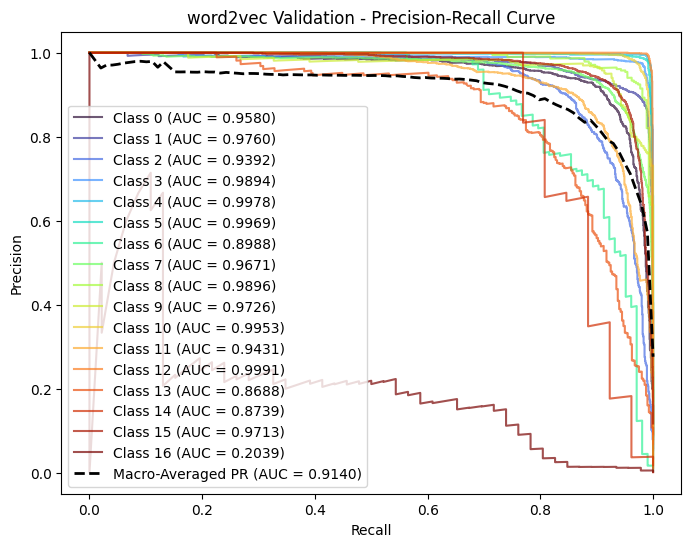

Training model configuration: Opimal
Epoch:    0 / 20 | Training Loss: 0.90004, Validation Loss: 0.50350
Epoch:    5 / 20 | Training Loss: 0.21443, Validation Loss: 0.30940
Early stopping triggered at epoch 8
Training complete. Best model found at epoch 6 with Validation Loss: 0.30940
Evaluating model configuration Opimal on Validation Set...
=== word2vec Validation Classification Report ===
              precision    recall  f1-score   support

           0     0.8930    0.9243    0.9083      1769
           1     0.9440    0.9003    0.9216      1965
           2     0.8791    0.8524    0.8656      1186
           3     0.9519    0.9877    0.9695      1303
           4     0.9892    0.9774    0.9833       753
           5     0.9860    0.9823    0.9842      1869
           6     0.7068    0.9126    0.7966       103
           7     0.9450    0.8849    0.9140      3787
           8     0.8866    0.9810    0.9314       263
           9     0.8364    0.9599    0.8939       474
          

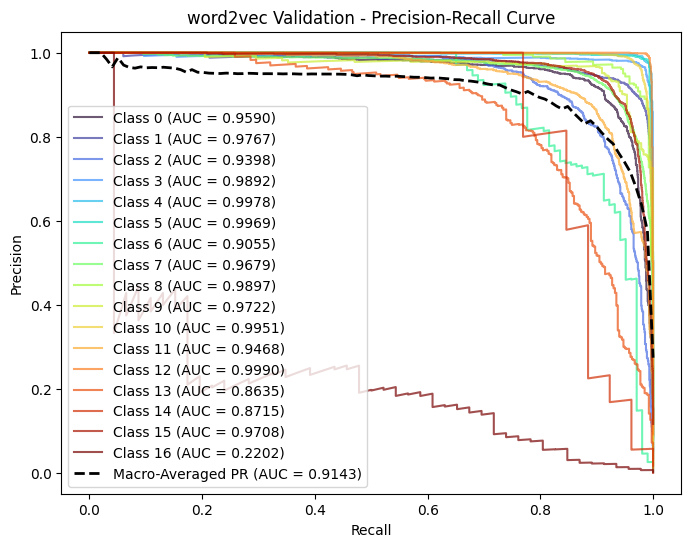

Training model configuration: 2
Epoch:    0 / 20 | Training Loss: 1.87076, Validation Loss: 0.91716
Epoch:    5 / 20 | Training Loss: 0.49768, Validation Loss: 0.40563
Early stopping triggered at epoch 10
Training complete. Best model found at epoch 8 with Validation Loss: 0.37095
Evaluating model configuration 2 on Validation Set...
=== word2vec Validation Classification Report ===
              precision    recall  f1-score   support

           0     0.8563    0.8790    0.8675      1769
           1     0.9318    0.8758    0.9029      1965
           2     0.8186    0.8297    0.8241      1186
           3     0.9174    0.9885    0.9516      1303
           4     0.9867    0.9867    0.9867       753
           5     0.9814    0.9593    0.9702      1869
           6     0.4340    0.8932    0.5841       103
           7     0.9310    0.8408    0.8836      3787
           8     0.8832    0.9772    0.9278       263
           9     0.7610    0.9873    0.8595       474
          10     0.

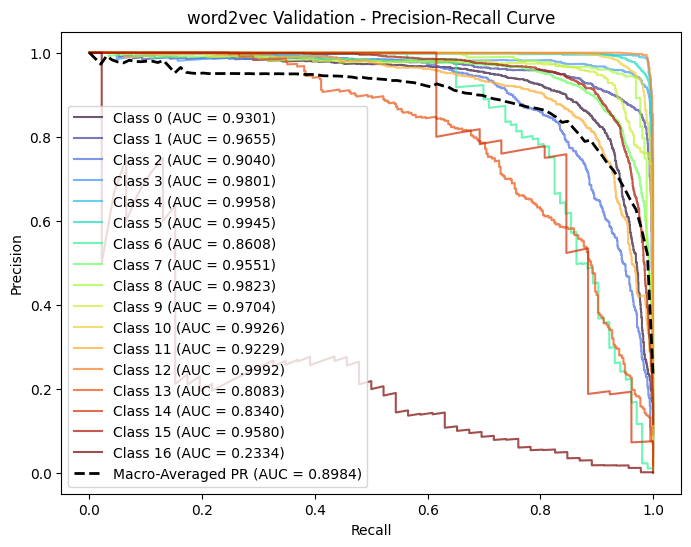

Training model configuration: 3
Epoch:    0 / 20 | Training Loss: 2.24229, Validation Loss: 1.25454
Epoch:    5 / 20 | Training Loss: 0.75353, Validation Loss: 0.49686
Epoch:   10 / 20 | Training Loss: 0.51633, Validation Loss: 0.40653
Epoch:   15 / 20 | Training Loss: 0.43641, Validation Loss: 0.38131
Early stopping triggered at epoch 17
Training complete. Best model found at epoch 15 with Validation Loss: 0.36832
Evaluating model configuration 3 on Validation Set...
=== word2vec Validation Classification Report ===
              precision    recall  f1-score   support

           0     0.8604    0.8881    0.8740      1769
           1     0.9298    0.8758    0.9020      1965
           2     0.8498    0.8204    0.8348      1186
           3     0.9225    0.9870    0.9537      1303
           4     0.9880    0.9880    0.9880       753
           5     0.9798    0.9593    0.9695      1869
           6     0.5000    0.8835    0.6386       103
           7     0.9266    0.8600    0.8921 

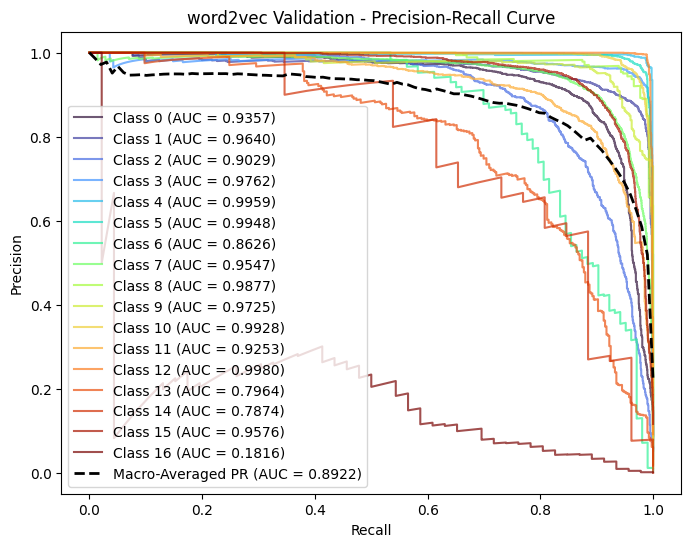

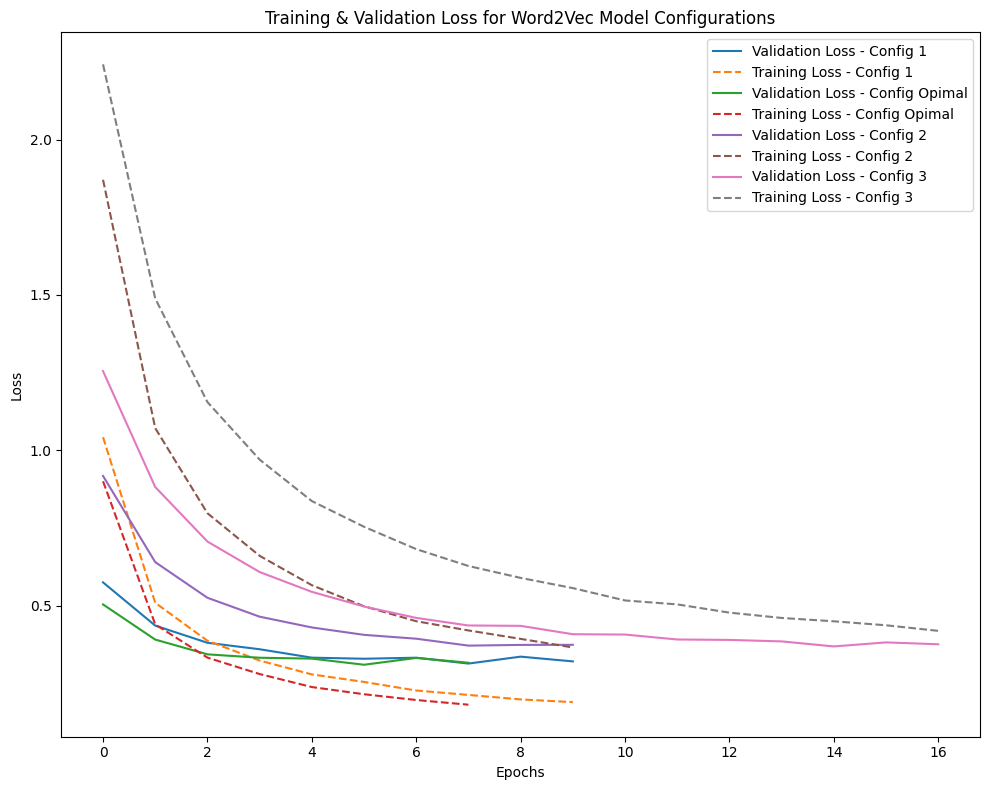

In [52]:
# Define model configurations for word2vec representation
representation_model_config = {
    "word2vec": {
        "1": {"hidden_layers": [512], "dropout": 0.6, "batch_norm": False, "layer_norm": True},
        "Opimal": {"hidden_layers": [1024], "dropout": 0.6, "batch_norm": False, "layer_norm": True},
        "2": {"hidden_layers": [256, 128], "dropout": 0.6, "batch_norm": False, "layer_norm": True},
        "3": {"hidden_layers": [128, 64], "dropout": 0.6, "batch_norm": False, "layer_norm": True}
    }
}

# Initialize results dictionary
results = {}
epochs = 20  # Number of epochs
batch_size = 256  # Batch size

# Create datasets and loaders for train, validation, and test sets
train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device),
                              torch.LongTensor(y_train_class_indices).to(device))
val_dataset = TensorDataset(torch.FloatTensor(X_dev).to(device),
                            torch.LongTensor(y_dev_class_indices).to(device))
test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device),
                             torch.LongTensor(y_test_class_indices).to(device))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Iterate over each model configuration
for config_name, model_config in representation_model_config["word2vec"].items():
    print(f"Training model configuration: {config_name}")

    # Extract settings for the current configuration
    hidden_layers = model_config["hidden_layers"]
    dropout = model_config["dropout"]
    batch_norm = model_config["batch_norm"]
    layer_norm = model_config["layer_norm"]

    # Initialize the model
    input_dim = X_train.shape[1]  # e.g., 900-dimensional input
    model = CustomModel(input_dim, hidden_layers=hidden_layers,
                        dropout=dropout, batch_norm=batch_norm,
                        layer_norm=layer_norm, classes_number=len(np.unique(y_train)),
                        device=device).float()

    # Initialize criterion (loss function) and optimizer
    class_counts = torch.bincount(y_train_class_indices)
    class_weights = 1.0 / class_counts.float()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train the model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

    print(f"Evaluating model configuration {config_name} on Validation Set...")
    y_val_true, y_val_pred, y_val_prob = evaluate_model(model, val_loader)
    val_pr_auc, report_val, mean_pr_val, mean_rc_val = compute_metrics(y_val_true, y_val_pred, y_val_prob, "word2vec", "Validation")

    # Store results for the current configuration
    results[config_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_metrics": val_pr_auc,
        "val_report": report_val,
        "mean_pr_val": mean_pr_val,
        "mean_rc_val": mean_rc_val
    }

# ========================== PLOTTING SECTION ===========================

# Plot Training & Validation Loss for each model configuration
fig, ax = plt.subplots(figsize=(10, 8))

for config_name, result in results.items():
    ax.plot(result["val_losses"], label=f"Validation Loss - Config {config_name}")
    ax.plot(result["train_losses"], linestyle='--', label=f"Training Loss - Config {config_name}")

# Add labels and title
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training & Validation Loss for Word2Vec Model Configurations")
ax.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()


###  Notes for the most Promissing Model 
- Based on the training and validation loss curves in the graph, the most promising model configuration appears to be `Config Optimal` (green and red dashed lines). 
    - Low Validation Loss:
        - The green line (Validation Loss - `Config Optimal` ) is among the lowest after several epochs, indicating good generalization.
    - Small Training-Validation Gap:
        - The red dashed line (Training Loss - `Config Optimal` ) is close to the green line, meaning it is not overfitting.
    - Stable Learning Trend:
        - The loss decreases smoothly without sudden spikes, suggesting the model is learning effectively.
- Config 2 seems to be the best choice because it has the lowest validation loss, a small generalization gap, and a smooth downward trend.

- In addition, because we wanted in parallel to check how well the model predocts with took in mind of metrics inclusding in classification report.
More specifically, we based on `accuracy` (of f1-score) and on `macro average` (of f1-score) and we additionally took in mind the score `macro Average PR (AUC)`
- The optimal model presented the better scores across all other models with the followings scores (it checked manually): 
    - accuracy : `0.9267`, macro avg : `0.8525` and macro avg PR (AUC) :  `0.9143`.

Epoch:    0 / 20 | Training Loss: 0.90418, Validation Loss: 0.51551
Epoch:    5 / 20 | Training Loss: 0.21433, Validation Loss: 0.32900
Early stopping triggered at epoch 9
Training complete. Best model found at epoch 7 with Validation Loss: 0.32639
Evaluating word2vec model on Train Set...
=== word2vec Train Classification Report ===
              precision    recall  f1-score   support

           0     0.9103    0.9404    0.9251     12590
           1     0.9637    0.8769    0.9183     17210
           2     0.9302    0.9080    0.9190      9815
           3     0.9600    0.9918    0.9757     10902
           4     0.9910    0.9943    0.9927      6538
           5     0.9880    0.9889    0.9885     16096
           6     0.6158    0.9984    0.7617       618
           7     0.9700    0.9075    0.9377     31819
           8     0.9252    0.9977    0.9601      2989
           9     0.7692    0.9934    0.8671      4422
          10     0.9894    0.9765    0.9829     17107
          11   

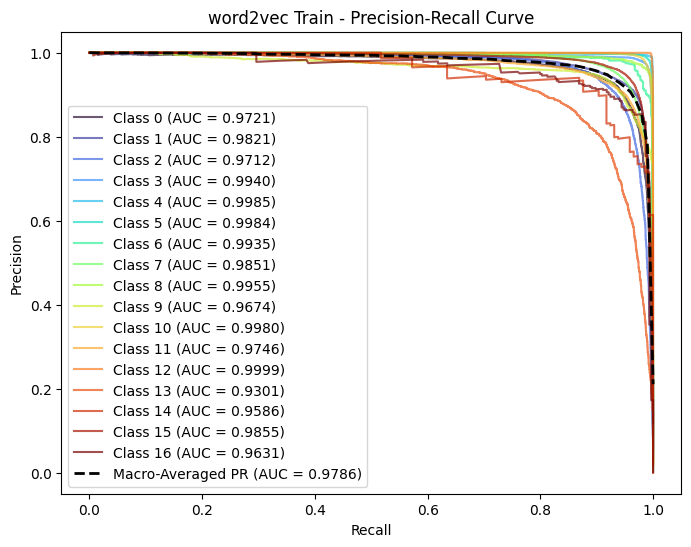

Evaluating word2vec model on Validation Set...
=== word2vec Validation Classification Report ===
              precision    recall  f1-score   support

           0     0.8923    0.9135    0.9028      1769
           1     0.9434    0.8814    0.9113      1965
           2     0.8962    0.8440    0.8693      1186
           3     0.9519    0.9877    0.9695      1303
           4     0.9906    0.9841    0.9873       753
           5     0.9829    0.9845    0.9837      1869
           6     0.5108    0.9223    0.6574       103
           7     0.9433    0.8838    0.9126      3787
           8     0.8678    0.9734    0.9176       263
           9     0.7635    0.9873    0.8611       474
          10     0.9818    0.9662    0.9739      2012
          11     0.8498    0.9014    0.8749      1532
          12     0.9980    0.9879    0.9929      2058
          13     0.7094    0.8321    0.7659       399
          14     0.3966    0.8846    0.5476        26
          15     0.9444    0.8956    0

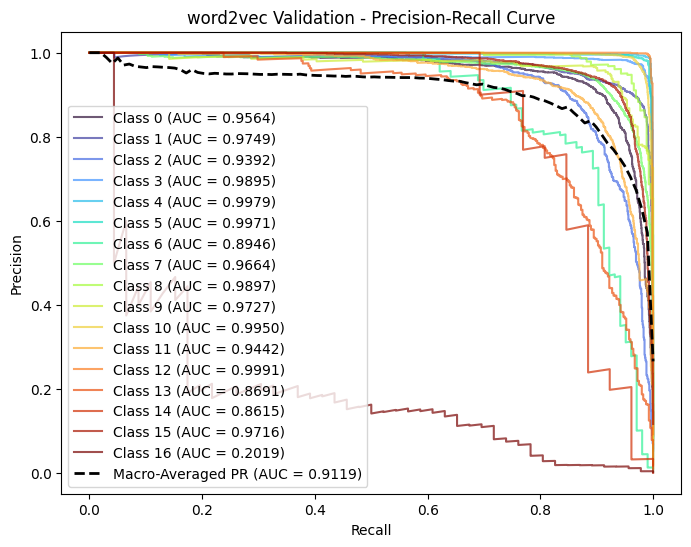

Evaluating word2vec model on Test Set...
=== word2vec Test Classification Report ===
              precision    recall  f1-score   support

           0     0.8805    0.9008    0.8905      1693
           1     0.9465    0.8772    0.9105      1955
           2     0.8988    0.8678    0.8830      1157
           3     0.9525    0.9873    0.9696      1258
           4     0.9818    0.9777    0.9797       717
           5     0.9757    0.9851    0.9804      1875
           6     0.5635    0.9107    0.6962       112
           7     0.9438    0.8548    0.8971      3732
           8     0.8649    0.9631    0.9114       379
           9     0.7608    0.9880    0.8596       499
          10     0.9864    0.9728    0.9795      1945
          11     0.8177    0.8957    0.8550      1688
          12     0.9990    0.9706    0.9846      2074
          13     0.7902    0.8640    0.8255       375
          14     0.3333    1.0000    0.5000        33
          15     0.9426    0.9105    0.9263      2

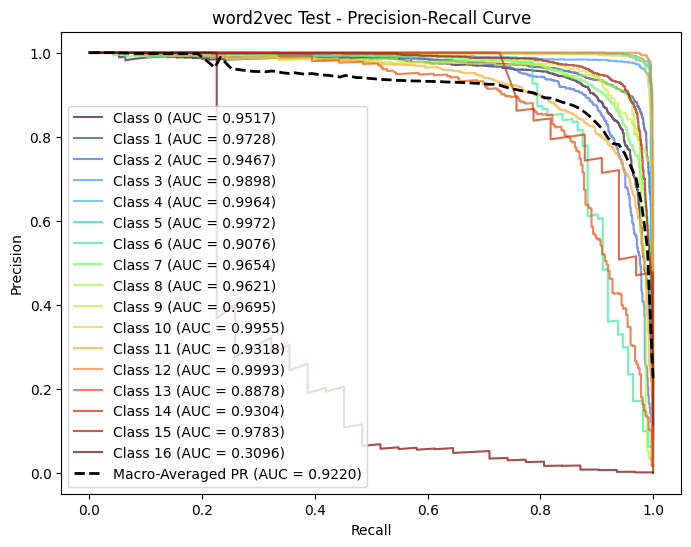

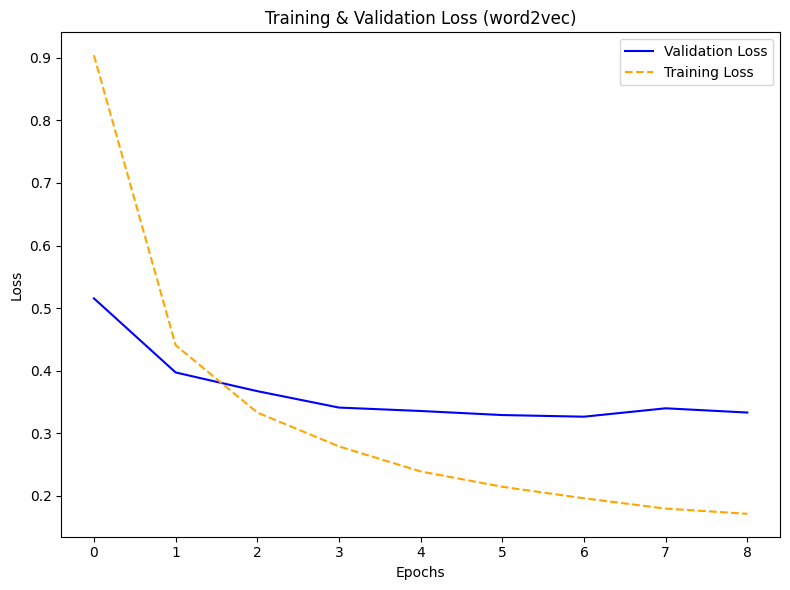

In [54]:
# Define model configuration for word2vec representation
representation_model_config = {
    "word2vec": {
        "Optimal": {"hidden_layers": [1024], "dropout": 0.6, "batch_norm": False, "layer_norm": True},
    }
}

# Initialize results dictionary
results = {}
epochs = 20  # Number of epochs
batch_size = 256  # Batch size

# Create datasets and loaders for train, validation, and test sets
train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device),
                               torch.LongTensor(y_train_class_indices).to(device))
val_dataset = TensorDataset(torch.FloatTensor(X_dev).to(device),
                             torch.LongTensor(y_dev_class_indices).to(device))
test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device),
                              torch.LongTensor(y_test_class_indices).to(device))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Extract settings for the word2vec representation
model_config = representation_model_config["word2vec"]["Optimal"]
hidden_layers = model_config["hidden_layers"]
dropout = model_config["dropout"]
batch_norm = model_config["batch_norm"]
layer_norm = model_config["layer_norm"]

# Initialize the model
input_dim = X_train.shape[1]  # 900-dimensional input
model = CustomModel(input_dim, hidden_layers=hidden_layers,
                    dropout=dropout, batch_norm=batch_norm,
                    layer_norm=layer_norm, classes_number=len(np.unique(y_train)),
                    device=device).float()

# Initialize criterion (loss function) and optimizer
class_counts = torch.bincount(y_train_class_indices)  
class_weights = 1.0 / class_counts.float()  
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

# Evaluate the model on train, validation, and test sets
print("Evaluating word2vec model on Train Set...")
y_train_true, y_train_pred, y_train_prob = evaluate_model(model, train_loader)
train_pr_auc, report_train, mean_pr_train, mean_rc_train = compute_metrics(y_train_true, y_train_pred, y_train_prob, "word2vec", "Train")

print("Evaluating word2vec model on Validation Set...")
y_val_true, y_val_pred, y_val_prob = evaluate_model(model, val_loader)
val_pr_auc, report_val, mean_pr_val, mean_rc_val = compute_metrics(y_val_true, y_val_pred, y_val_prob, "word2vec", "Validation")

print("Evaluating word2vec model on Test Set...")
y_test_true, y_test_pred, y_test_prob = evaluate_model(model, test_loader)
test_pr_auc, report_test, mean_pr_test, mean_rc_test = compute_metrics(y_test_true, y_test_pred, y_test_prob, "word2vec", "Test")

# Store results in a simplified structure
results["word2vec"] = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_metrics": train_pr_auc,
    "val_metrics": val_pr_auc,
    "test_metrics": test_pr_auc,
    "train_report": report_train,
    "val_report": report_val,
    "test_report": report_test,
    "mean_pr_train": mean_pr_train,
    "mean_rc_train": mean_rc_train,
    "mean_pr_val": mean_pr_val,
    "mean_rc_val": mean_rc_val,
    "mean_pr_test": mean_pr_test,
    "mean_rc_test": mean_rc_test
}

# ========================== PLOTTING SECTION ===========================

# Plot Training & Validation Loss for the word2vec model
fig, ax = plt.subplots(figsize=(8, 6))

# Extract the results for word2vec model
result = results["word2vec"]
ax.plot(result["val_losses"], label="Validation Loss", color="blue")
ax.plot(result["train_losses"], linestyle='--', label="Training Loss", color="orange")

# Add labels and title
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training & Validation Loss (word2vec)")
ax.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()


### Interpretation of Training & Validation Loss (word2vec)

1. **Training Loss (Orange) Decreases Steadily**  
   - Indicates the model is learning effectively over epochs.

2. **Validation Loss (Blue) Starts Decreasing but then Plateaus**  
   - Suggests the model's performance on unseen data stops improving after a few epochs.

3. **Gap Between Training and Validation Loss Increases**  
   - Potential sign of **overfitting**, where the model learns the training data well but struggles to generalize.



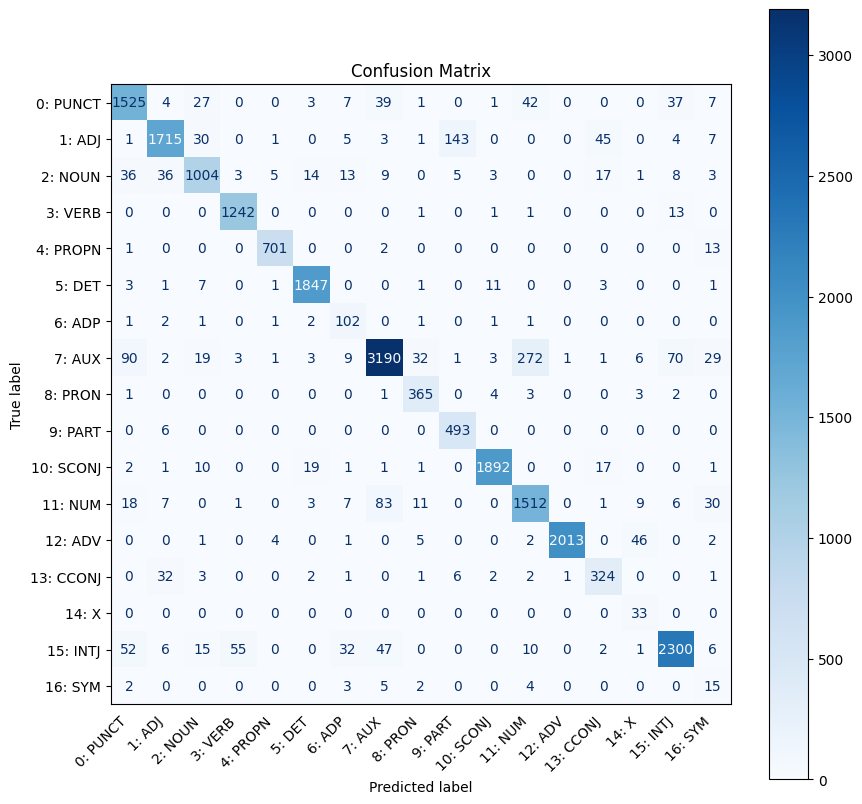

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


class_labels = list(y_train.unique()) 
class_labels_with_numbers = [f"{i}: {label}" for i, label in enumerate(class_labels)]

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_with_numbers)

fig, ax = plt.subplots(figsize=(10, 10)) 
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xticks(np.arange(len(class_labels_with_numbers))) 
ax.set_xticklabels(class_labels_with_numbers, rotation=45, ha="right")
ax.tick_params(axis='x', which='both', bottom=False, top=False)  
plt.title("Confusion Matrix")
plt.show()


- confusion matrics help us to identify potential classes taht are confused.
    - It is a great tool for error analysis. 
### Interpretation of Confusion Matrix

1. **Strong Diagonal Values**  
   - Most predictions are correctly classified, as indicated by the strong diagonal presence.

2. **Highest Correct Predictions for 'AUX' (3190) and 'INTJ' (2300)**  
   - The model performs well in predicting these categories.

3. **Misclassification in Similar Categories**  
   - Words like **ADJ (Adjective) and NOUN**, **PUNCT (Punctuation) and SYM (Symbol)** show minor misclassification, likely due to linguistic overlap.

4. **Notable Errors in 'AUX' and 'PUNCT'**  
   - 'AUX' is sometimes misclassified into categories like **VERB** (common linguistic confusion).

5. **Rare Labels Have More Misclassifications**  
   - Less frequent labels such as **X** and **SYM** have more misclassifications due to data imbalance.


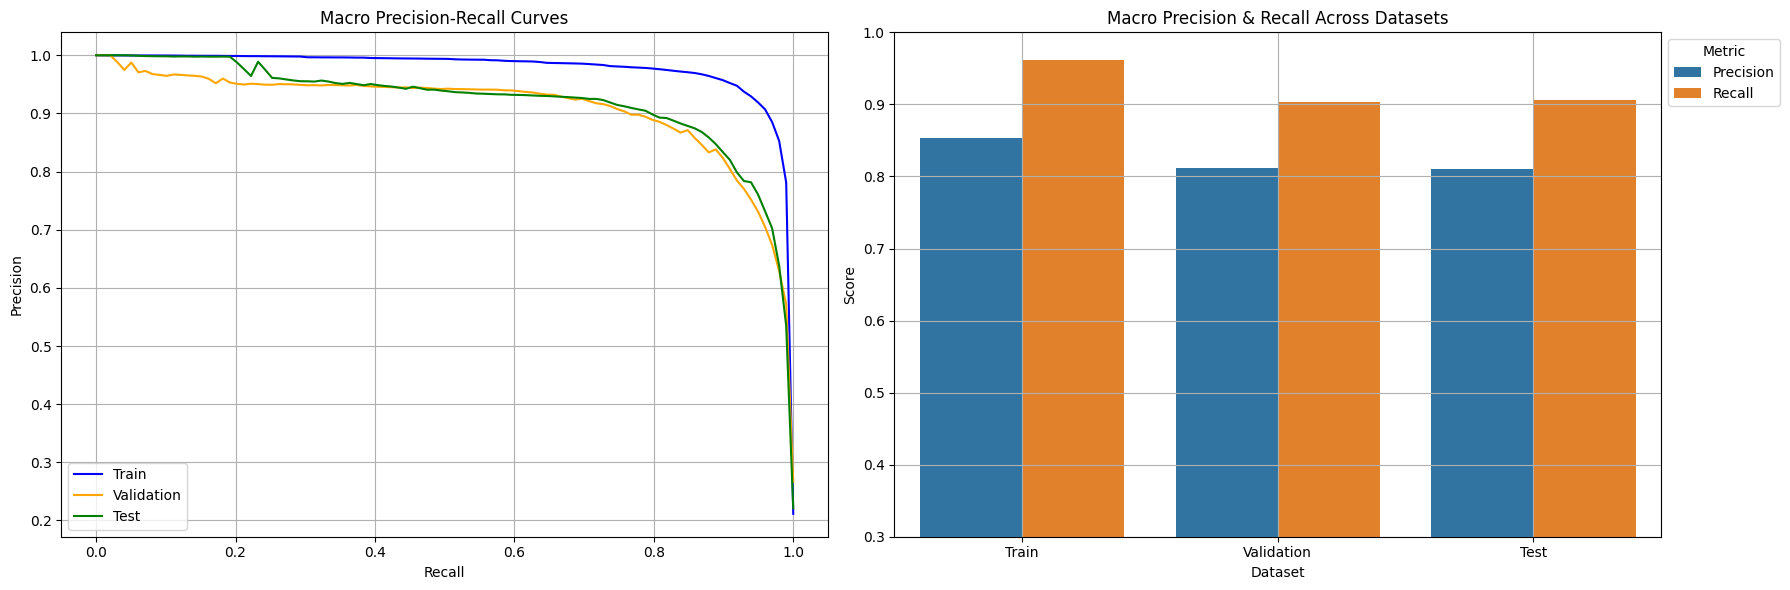

In [56]:
model_key = "word2vec"
result = results[model_key]

# Define dictionaries for macro precision-recall curves for each dataset
mean_precisions = {
    "Train": result["mean_pr_train"],
    "Validation": result["mean_pr_val"],
    "Test": result["mean_pr_test"]
}
mean_recalls = {
    "Train": result["mean_rc_train"],
    "Validation": result["mean_rc_val"],
    "Test": result["mean_rc_test"]
}

datasets = ["Train", "Validation", "Test"]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --------------------------
# Left subplot: Precision-Recall Curves
# --------------------------
ax1 = axes[0]
colors = {"Train": "blue", "Validation": "orange", "Test": "green"}
for ds in datasets:
    ax1.plot(mean_recalls[ds], mean_precisions[ds], label=ds, color=colors[ds])
ax1.set_title("Macro Precision-Recall Curves")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()
ax1.grid(True)

# --------------------------
# Right subplot: Grouped Bar Plot for Macro Precision and Recall
macro_data = []
for ds in datasets:
    if ds == "Train":
        macro_data.append({
            "Dataset": ds, 
            "Metric": "Precision", 
            "Score": result["train_report"]["macro avg"]["precision"]
        })
        macro_data.append({
            "Dataset": ds, 
            "Metric": "Recall", 
            "Score": result["train_report"]["macro avg"]["recall"]
        })
    elif ds == "Validation":
        macro_data.append({
            "Dataset": ds, 
            "Metric": "Precision", 
            "Score": result["val_report"]["macro avg"]["precision"]
        })
        macro_data.append({
            "Dataset": ds, 
            "Metric": "Recall", 
            "Score": result["val_report"]["macro avg"]["recall"]
        })
    elif ds == "Test":
        macro_data.append({
            "Dataset": ds, 
            "Metric": "Precision", 
            "Score": result["test_report"]["macro avg"]["precision"]
        })
        macro_data.append({
            "Dataset": ds, 
            "Metric": "Recall", 
            "Score": result["test_report"]["macro avg"]["recall"]
        })

df_macro = pd.DataFrame(macro_data)

ax2 = axes[1]
sns.barplot(x="Dataset", y="Score", hue="Metric", data=df_macro, ax=ax2)
ax2.set_title("Macro Precision & Recall Across Datasets")
ax2.set_ylim(0.3, 1.0) 
ax2.grid(True)
ax2.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Interpretation of Macro Precision-Recall Curve

1. **Training Curve (Blue) is Higher than Validation (Orange) and Test (Green)**  
   - The model performs best on the training set, indicating possible overfitting.

2. **Validation and Test Curves are Close**  
   - This suggests good generalization, as both sets have similar performance.

3. **Precision Drops Sharply at High Recall**  
   - The model struggles to maintain precision when recall is high, indicating more false positives at higher recall levels.
### Interpretation of Macro Precision & Recall Across Datasets

1. **Recall (Orange) is Higher than Precision (Blue) Across All Datasets**  
   - The model prioritizes recall, meaning it captures more relevant instances but may have more false positives.

2. **Training Precision is Slightly Higher than Validation & Test**  
   - Indicates possible overfitting, as precision drops on unseen data.

3. **Validation and Test Scores are Similar**  
   - Suggests good generalization, with no major performance drop between validation and test sets.


### Comparison Baseline (Majority) vs Optimal MLP Conclusion Based on the "summry values of accuracy (f1 score) and macro avg (f1 score)"
- Accuracy (f1_score): 
   - Majority Baseline = `0.86` < Optimal MLP `0.91`
- Macro AVG (f1 score):
   - Majority Baseline = `0.80` < Optimal MLP `0.83`
- This demonstrates that the Optimal MLP model achieves better overall classification performance, particularly in handling class imbalances, as indicated by the improvement in the macro-averaged F1 score.
